In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import joblib
import requests

In [3]:
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

# Загрузка необходимых данных NLTK
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vova_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\vova_\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Чтение данных

In [4]:
data=pd.read_csv("website_classification.csv")
data.head()

,Unnamed: 0,website_url,cleaned_website_text,Category
0,0,https://www.booking.com/index.html?aid=1743217,official site good hotel accommodation big sav...,Travel
1,1,https://travelsites.com/expedia/,expedia hotel book sites like use vacation wor...,Travel
2,2,https://travelsites.com/tripadvisor/,tripadvisor hotel book sites like previously d...,Travel
3,3,https://www.momondo.in/?ispredir=true,cheap flights search compare flights momondo f...,Travel
4,4,https://www.ebookers.com/?AFFCID=EBOOKERS-UK.n...,bot create free account create free account si...,Travel


# Подготовка данных

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1408 entries, 0 to 1407
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Unnamed: 0            1408 non-null   int64 
 1   website_url           1408 non-null   object
 2   cleaned_website_text  1408 non-null   object
 3   Category              1408 non-null   object
dtypes: int64(1), object(3)
memory usage: 44.1+ KB


In [6]:
columns_to_drop = ["Unnamed: 0", "website_url"]
existing_columns = [col for col in columns_to_drop if col in data.columns]

if existing_columns:
    data = data.drop(existing_columns, axis=1)

In [7]:
data.head()

,cleaned_website_text,Category
0,official site good hotel accommodation big sav...,Travel
1,expedia hotel book sites like use vacation wor...,Travel
2,tripadvisor hotel book sites like previously d...,Travel
3,cheap flights search compare flights momondo f...,Travel
4,bot create free account create free account si...,Travel


In [8]:
data=data.drop_duplicates()
data.isnull().sum()

cleaned_website_text    0
Category                0
dtype: int64

In [9]:
feature=data['cleaned_website_text']
target=data['Category']
feature=pd.DataFrame(feature)

In [10]:
class_names = target.unique()
class_names

array(['Travel', 'Social Networking and Messaging', 'News',
       'Streaming Services', 'Sports', 'Photography',
       'Law and Government', 'Health and Fitness', 'Games', 'E-Commerce',
       'Forums', 'Food', 'Education', 'Computers and Technology',
       'Business/Corporate', 'Adult'], dtype=object)

In [11]:
label_encoder=LabelEncoder()
target=label_encoder.fit_transform(target)

encoder_filename = 'label_encoder.pkl'
joblib.dump(label_encoder, encoder_filename)
print(f"LabelEncoder saved to {encoder_filename}")

target

LabelEncoder saved to label_encoder.pkl


array([15, 15, 15, ...,  0,  0,  0])

In [12]:
def cleaning_processing(sentence):
    stop_words = set(stopwords.words('english'))
    sentence = word_tokenize(sentence)  # Разделение предложения на слова
    sen = []
    for i in sentence:
        word = i.lower()  # Преобразование в нижний регистр
        word = re.sub(r"[^a-zA-Z]", "", word)  # Удаление специальных символов
        if word not in stop_words:
            if word != '':  # Удаление пустых строк
                sen.append(word)
    filtered_sentence = " ".join(sen)  # Преобразование списка слов обратно в строку
    return filtered_sentence

In [13]:
feature["cleaned_website_text"]=feature["cleaned_website_text"].apply(cleaning_processing)

# Очищенные данные от часто использованных слов, от специальных символов в нижнем регистре

In [14]:
feature.head()

,cleaned_website_text
0,official site good hotel accommodation big sav...
1,expedia hotel book sites like use vacation wor...
2,tripadvisor hotel book sites like previously d...
3,cheap flights search compare flights momondo f...
4,bot create free account create free account si...


# Преобразование текстовых данных в числовые векторы с использованием метода TF-IDF

TF-IDF (Term Frequency-Inverse Document Frequency) — это метод оценки важности слова в документе по сравнению с набором документов (корпусом).

## Терминология

- **TF (Term Frequency)**: Частота терма. Количество раз, которое слово встречается в документе, делённое на общее количество слов в документе.
- **IDF (Inverse Document Frequency)**: Обратная частота документа. Логарифм отношения общего количества документов к количеству документов, содержащих данное слово.


In [15]:
con_vector=TfidfVectorizer()
feature=con_vector.fit_transform(feature["cleaned_website_text"])

vectorizer_filename = 'tfidf_vectorizer.pkl'
joblib.dump(con_vector, vectorizer_filename)
print(f"TF-IDF Vectorizer saved to {vectorizer_filename}")

TF-IDF Vectorizer saved to tfidf_vectorizer.pkl


In [16]:
feature_names = con_vector.get_feature_names_out()

In [17]:
feature_names

array(['aa', 'aaa', 'aaaannnnnd', ..., 'zyt', 'zz', 'zzp'], dtype=object)

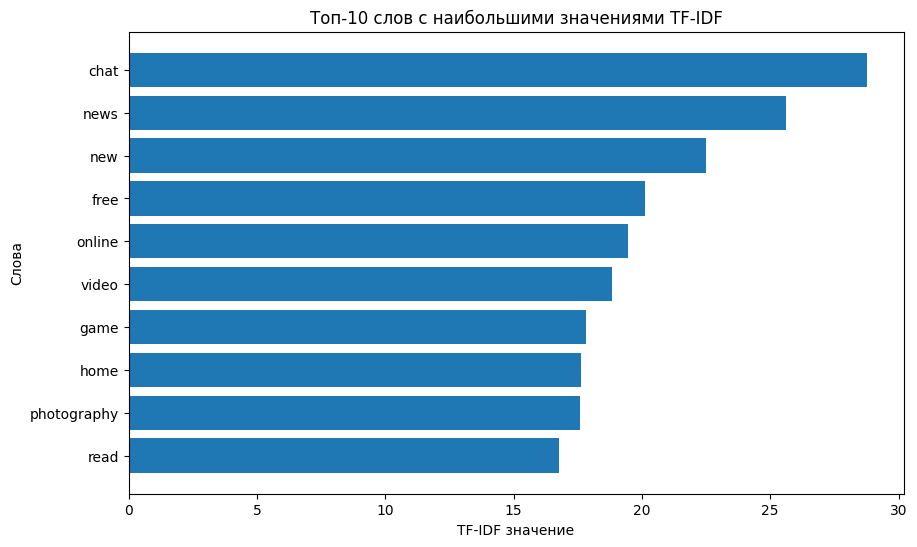

In [18]:
tfidf_sum = np.sum(feature, axis=0).A1  # Преобразуем в одномерный массив

top_n = 10
top_n_indices = np.argsort(tfidf_sum)[-top_n:]
top_words = [(feature_names[i], tfidf_sum[i]) for i in top_n_indices]
words, values = zip(*top_words)

# Преобразование кортежей в списки для построения графика
words = list(words)
values = list(values)

# Построим график
plt.figure(figsize=(10, 6))
plt.barh(words, values)
plt.title("Топ-10 слов с наибольшими значениями TF-IDF")
plt.xlabel("TF-IDF значение")
plt.ylabel("Слова")
plt.show()

# Разделим данные на обучающую и тестовую выборки

In [19]:
x_train,x_test,y_train,y_test=train_test_split(feature,target,test_size=0.2, random_state=42)

In [20]:
print("X_train shape:", x_train.shape)
print("X_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1100, 58170)
X_test shape: (275, 58170)
y_train shape: (1100,)
y_test shape: (275,)


# Выберем наилучшую модель

In [21]:
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

## KNeighborsClassifier

In [22]:
classifier1=KNeighborsClassifier()
classifier1.fit(x_train,y_train)
predict1=classifier1.predict(x_test)
accuracy1 = accuracy_score(y_test, predict1)
print("KNeighborsClassifier accuracy score: ",accuracy1)

KNeighborsClassifier accuracy score:  0.8363636363636363


['Adult' 'Business/Corporate' 'Computers and Technology' 'E-Commerce'
 'Education' 'Food' 'Forums' 'Games' 'Health and Fitness'
 'Law and Government' 'News' 'Photography'
 'Social Networking and Messaging' 'Sports' 'Streaming Services' 'Travel']


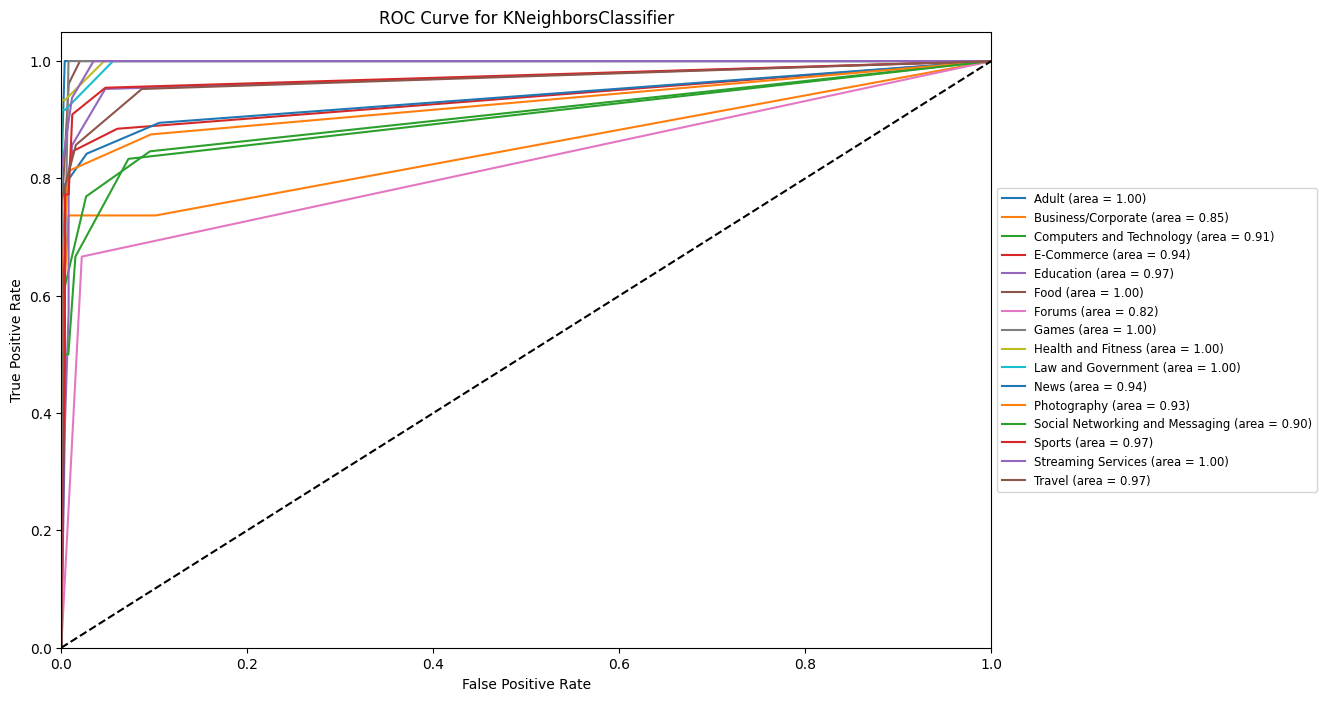

In [23]:
# Получение уникальных имен классов
class_names = label_encoder.inverse_transform(np.unique(target))
print(class_names)

# Для построения ROC-кривой нужно, чтобы классификатор возвращал вероятности
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

y_score = classifier1.predict_proba(x_test)

# Расчет ROC-кривой и AUC для каждого класса
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Построение ROC-кривой для каждого класса
plt.figure(figsize=(12, 8))  # Увеличиваем размер фигуры
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for KNeighborsClassifier')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small')  # Изменяем расположение легенды и размер шрифта
plt.show()

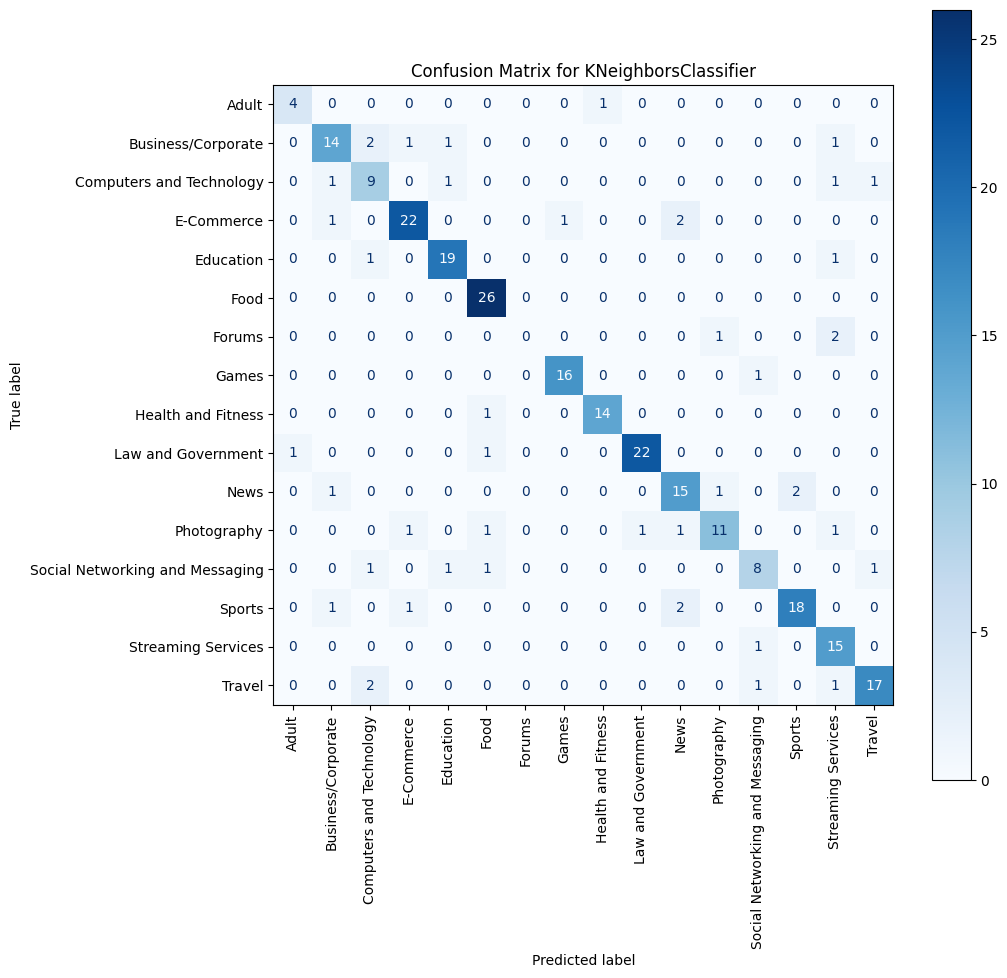

In [24]:
cm = confusion_matrix(y_test, predict1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Увеличение размера фигуры
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix for KNeighborsClassifier")
plt.xticks(rotation=90) 
plt.show()


## DecisionTreeClassifier

In [25]:
classifier2=DecisionTreeClassifier()
classifier2.fit(x_train,y_train)
predict2=classifier2.predict(x_test)
accuracy2 = accuracy_score(y_test, predict2)
print("DecisionTreeClassifier accuracy score: ",accuracy2)

DecisionTreeClassifier accuracy score:  0.5890909090909091


['Adult' 'Business/Corporate' 'Computers and Technology' 'E-Commerce'
 'Education' 'Food' 'Forums' 'Games' 'Health and Fitness'
 'Law and Government' 'News' 'Photography'
 'Social Networking and Messaging' 'Sports' 'Streaming Services' 'Travel']


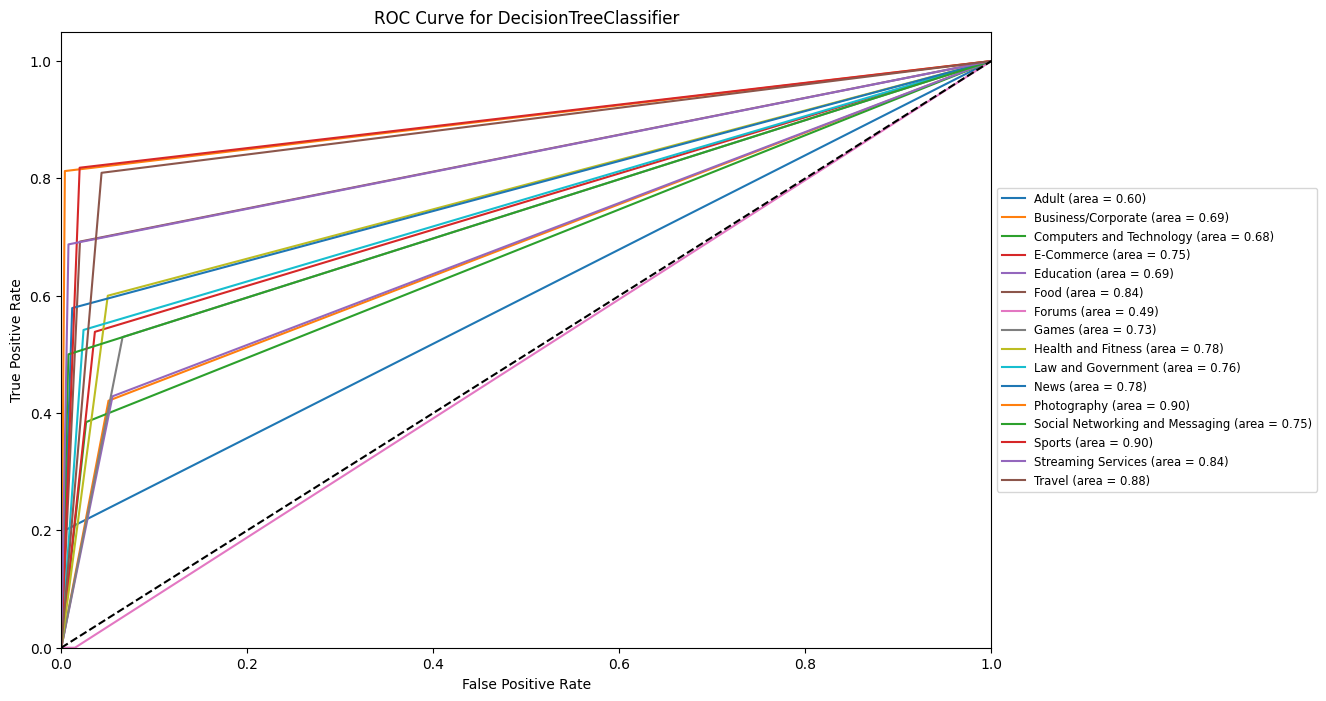

In [26]:
# Получение уникальных имен классов
class_names = label_encoder.inverse_transform(np.unique(target))
print(class_names)

# Для построения ROC-кривой нужно, чтобы классификатор возвращал вероятности
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

y_score = classifier2.predict_proba(x_test)

# Расчет ROC-кривой и AUC для каждого класса
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Построение ROC-кривой для каждого класса
plt.figure(figsize=(12, 8))  # Увеличиваем размер фигуры
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for DecisionTreeClassifier')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small')  # Изменяем расположение легенды и размер шрифта
plt.show()

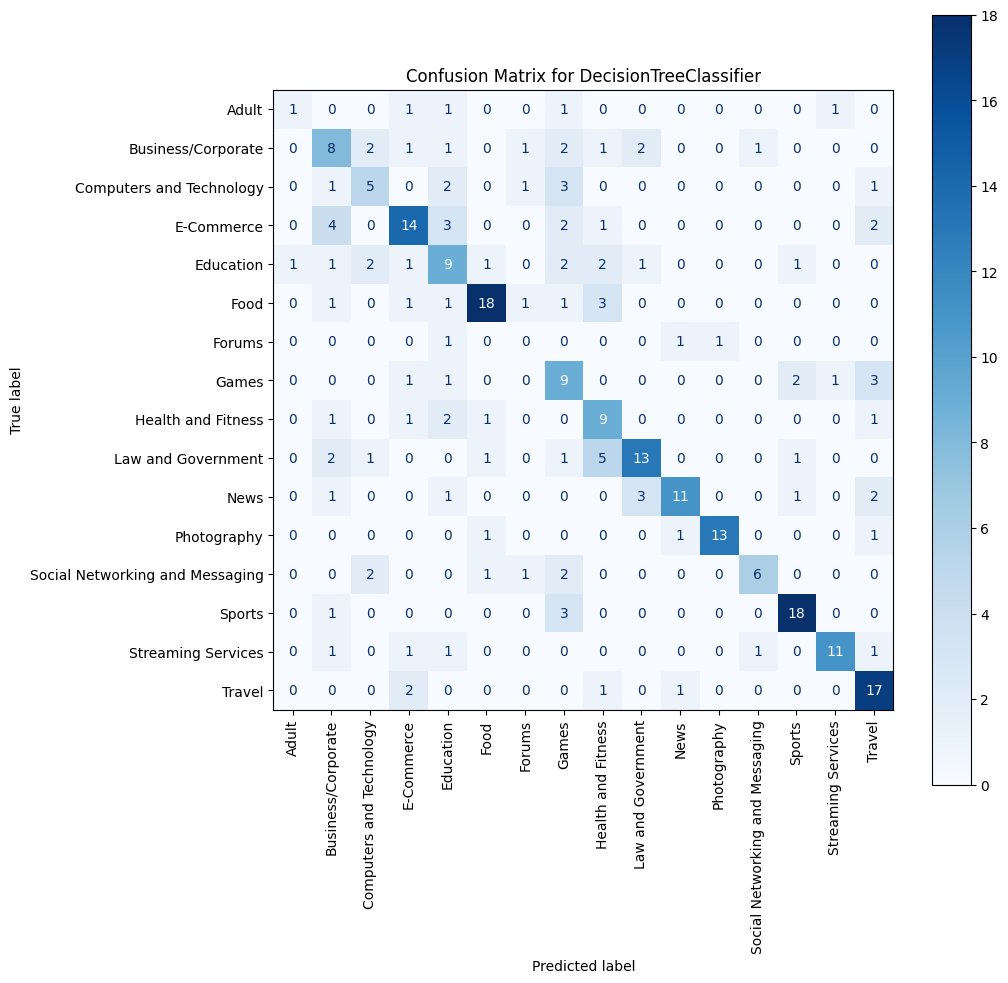

In [27]:
cm = confusion_matrix(y_test, predict2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Увеличение размера фигуры
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix for DecisionTreeClassifier")
plt.xticks(rotation=90) 
plt.show()

## MultinomialNB

In [28]:
classifier3=MultinomialNB()
classifier3.fit(x_train,y_train)

model_filename = 'multinomial_nb_model.pkl'
joblib.dump(classifier3, model_filename)
print(f"Model saved to {model_filename}")

predict3=classifier3.predict(x_test)
accuracy3 = accuracy_score(y_test, predict3)
print("MultinomialNB accuracy score: ",accuracy3)

Model saved to multinomial_nb_model.pkl
MultinomialNB accuracy score:  0.8581818181818182


['Adult' 'Business/Corporate' 'Computers and Technology' 'E-Commerce'
 'Education' 'Food' 'Forums' 'Games' 'Health and Fitness'
 'Law and Government' 'News' 'Photography'
 'Social Networking and Messaging' 'Sports' 'Streaming Services' 'Travel']


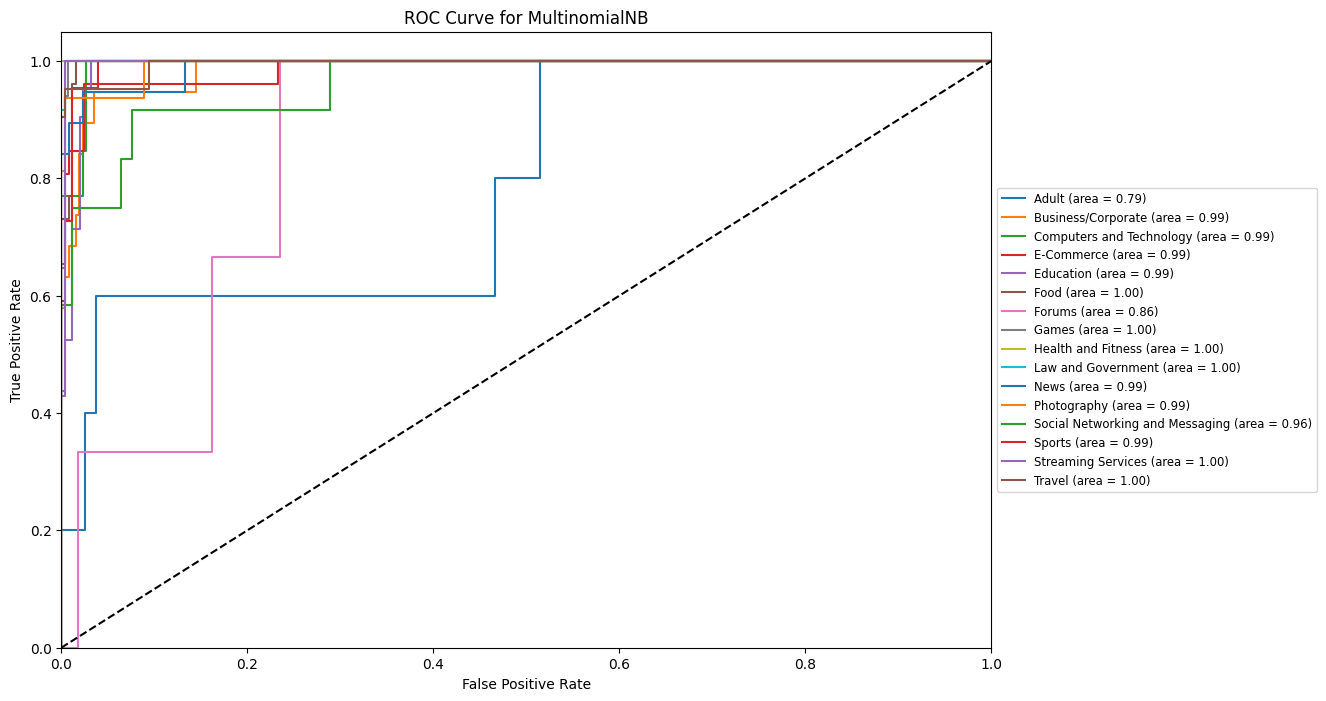

In [29]:
# Получение уникальных имен классов
class_names = label_encoder.inverse_transform(np.unique(target))
print(class_names)

# Для построения ROC-кривой нужно, чтобы классификатор возвращал вероятности
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

y_score = classifier3.predict_proba(x_test)

# Расчет ROC-кривой и AUC для каждого класса
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Построение ROC-кривой для каждого класса
plt.figure(figsize=(12, 8))  # Увеличиваем размер фигуры
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for MultinomialNB')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small')  # Изменяем расположение легенды и размер шрифта
plt.show()

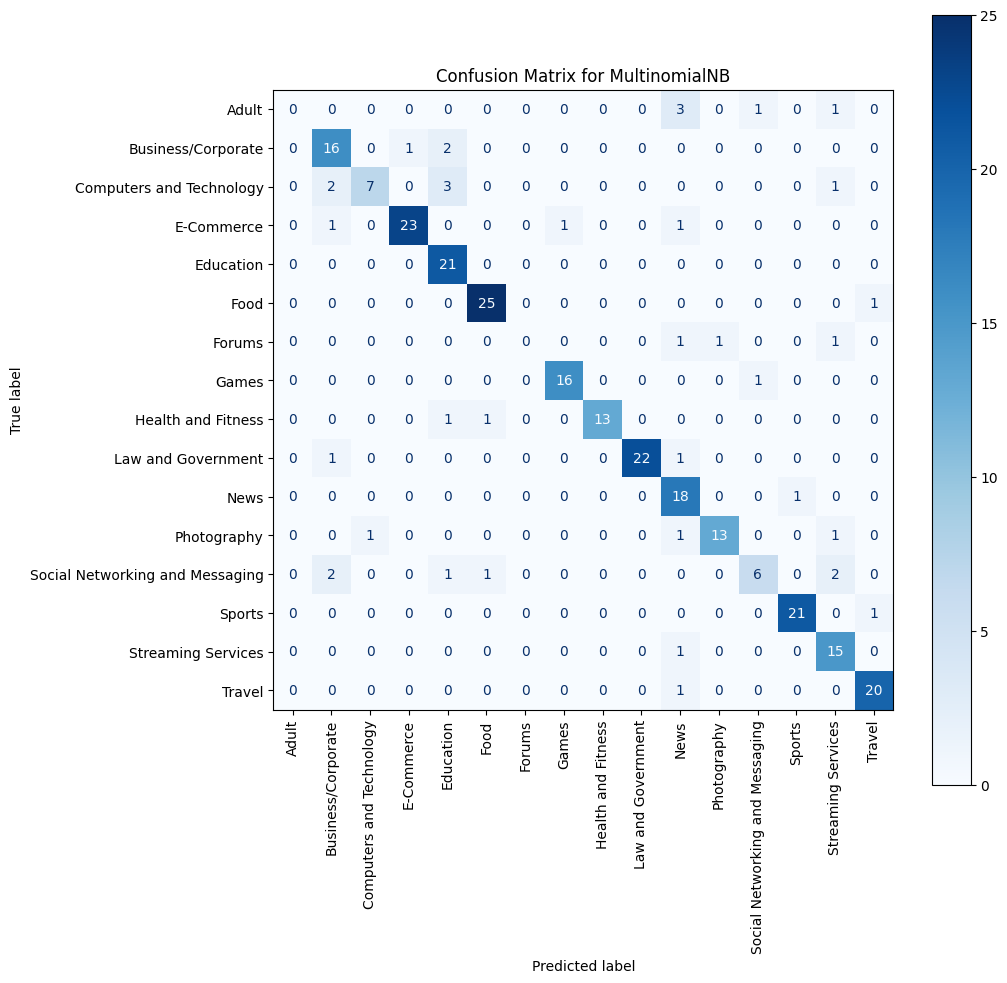

In [30]:
cm = confusion_matrix(y_test, predict3)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Увеличение размера фигуры
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix for MultinomialNB")
plt.xticks(rotation=90) 
plt.show()

## SVC

In [31]:
classifier4=SVC(probability=True)
classifier4.fit(x_train,y_train)
predict4=classifier4.predict(x_test)
accuracy4 = accuracy_score(y_test, predict4)
print("SVC accuracy score: ",accuracy4)

SVC accuracy score:  0.8109090909090909


['Adult' 'Business/Corporate' 'Computers and Technology' 'E-Commerce'
 'Education' 'Food' 'Forums' 'Games' 'Health and Fitness'
 'Law and Government' 'News' 'Photography'
 'Social Networking and Messaging' 'Sports' 'Streaming Services' 'Travel']


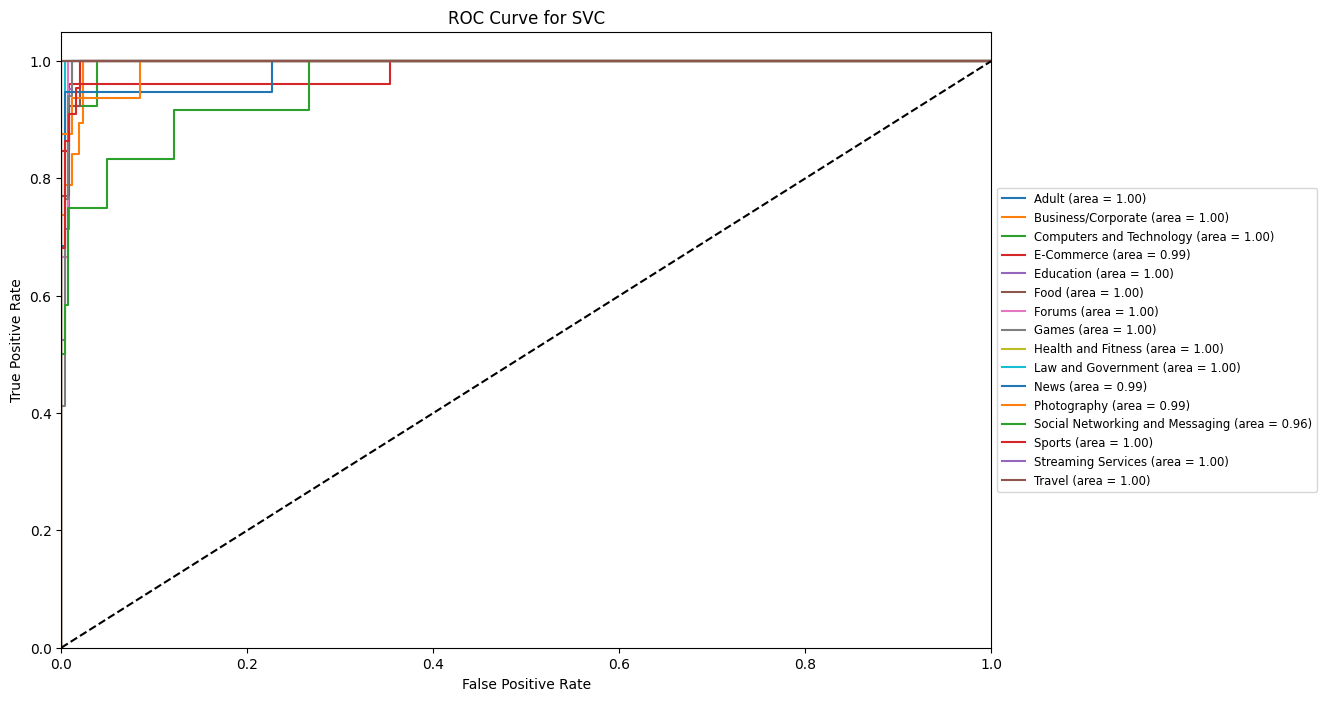

In [32]:
# Получение уникальных имен классов
class_names = label_encoder.inverse_transform(np.unique(target))
print(class_names)

# Для построения ROC-кривой нужно, чтобы классификатор возвращал вероятности
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

y_score = classifier4.predict_proba(x_test)

# Расчет ROC-кривой и AUC для каждого класса
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Построение ROC-кривой для каждого класса
plt.figure(figsize=(12, 8))  # Увеличиваем размер фигуры
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (area = {roc_auc[i]:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SVC')
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize='small')  # Изменяем расположение легенды и размер шрифта
plt.show()

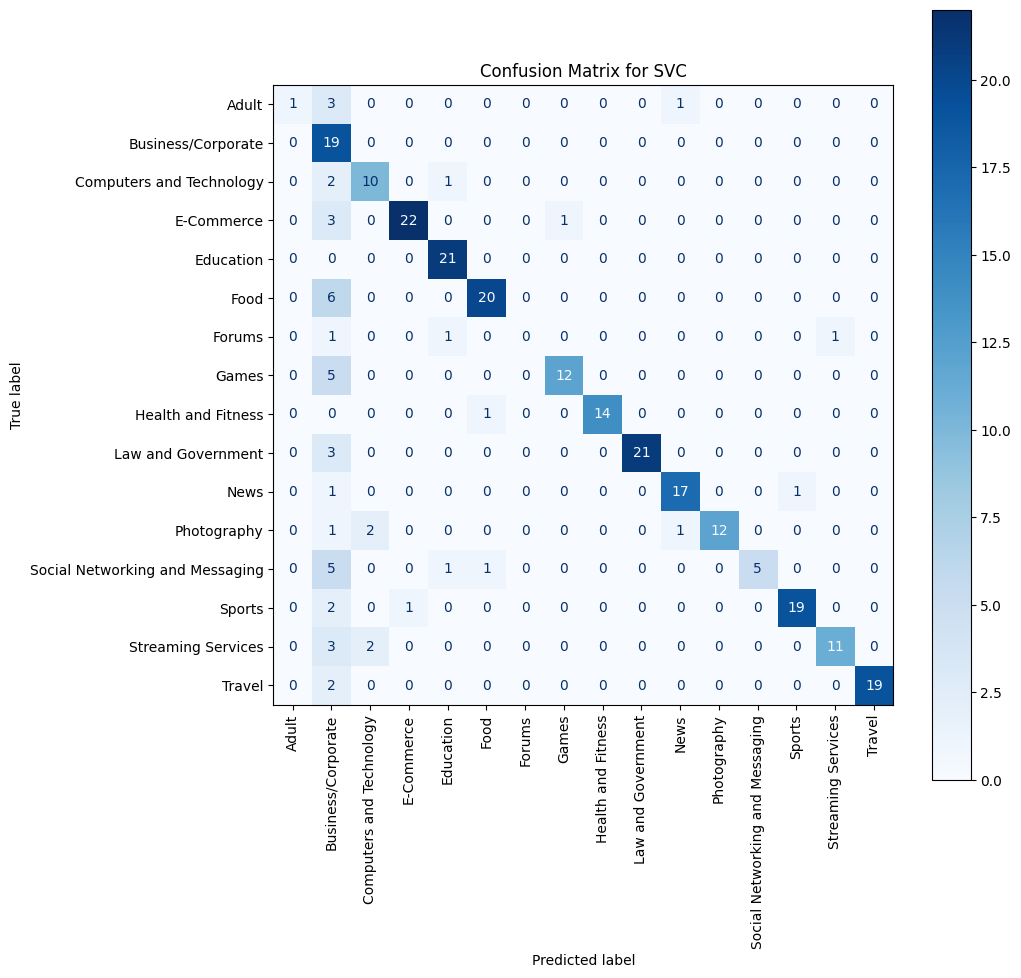

In [33]:
cm = confusion_matrix(y_test, predict4)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

# Увеличение размера фигуры
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title("Confusion Matrix for SVC")
plt.xticks(rotation=90) 
plt.show()

# График точности моделей

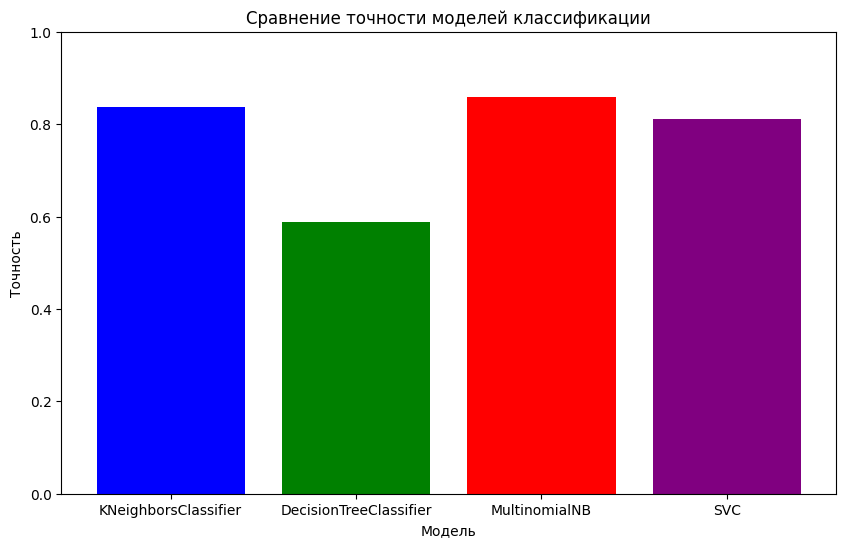

In [34]:
# Построение графика точностей моделей
model_names = ["KNeighborsClassifier", "DecisionTreeClassifier", "MultinomialNB", "SVC"]
accuracy_values = [accuracy1, accuracy2, accuracy3, accuracy4]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_values, color=['blue', 'green', 'red', 'purple'])
plt.title("Сравнение точности моделей классификации")
plt.xlabel("Модель")
plt.ylabel("Точность")
plt.ylim(0, 1)  # Установим границы по оси Y от 0 до 1
plt.show()

# Выбираем модель
На основе точностей моделей и матрицы ошибок выберу модель MultinominalNB, хоть и на ROC - кривой лучше себя показала SVC, что можно объяснить малым количеством тестовых данных

# Проверка на собственном датасете Российских сайтах

In [53]:
demodata=pd.read_csv("demo.csv")
demodata.head()

,индекс,URL-адрес веб-сайта,Категория URL-адреса,Unnamed: 3
0,0,https://www.duolingo.com/,Образование,NaN
1,1,https://ege.sdamgia.ru,Образование,NaN
2,2,https://skyeng.ru,Образование,NaN
3,3,https://notion.so,Образование,NaN
4,4,https://landings.lingualeo.com,Образование,NaN


In [54]:
columns_to_drop = ["индекс", "Unnamed: 3"]
existing_columns = [col for col in columns_to_drop if col in demodata.columns]

if existing_columns:
    demodata = demodata.drop(existing_columns, axis=1)
demodata

,URL-адрес веб-сайта,Категория URL-адреса
0,https://www.duolingo.com/,Образование
1,https://ege.sdamgia.ru,Образование
2,https://skyeng.ru,Образование
3,https://notion.so,Образование
4,https://landings.lingualeo.com,Образование
...,...,...
70,https://kinopoisk.ru,Развлекательные
71,https://vkplay.ru,Развлекательные
72,https://dzen.ru,Развлекательные
73,https://yandexmusic.ru,Развлекательные


In [44]:
demodata=demodata.drop_duplicates()
demodata.isnull().sum()

URL-адрес веб-сайта     0
Категория URL-адреса    0
dtype: int64

In [42]:
demotarget=demodata['Категория URL-адреса']
demo_class_names = demotarget.unique()
demo_class_names

array(['Образование', 'Развлекательные'], dtype=object)

## Делаем запросы на flask сервер и сверяем полученные категории

In [47]:
def get_category(url):
    try:
        response = requests.post('http://localhost:5000/predict', json={'url': url})
        if response.status_code == 200:
            return response.json().get('category')
        else:
            return 'Error'
    except Exception as e:
        return 'Error'

# Создание списка для хранения результатов
results = []

# Выполнение запросов для каждого URL
for index, row in demodata.iterrows():
    url = row['URL-адрес веб-сайта']
    category = get_category(url)
    results.append({'URL-адрес веб-сайта': url, 'Категория URL-адреса': category})

# Преобразование списка результатов в DataFrame
results_df = pd.DataFrame(results)

# Сохранение результатов в CSV
results_df.to_csv('predicted_categories.csv', index=False)

# Вывод результатов
results_df.head()

,URL-адрес веб-сайта,Категория URL-адреса
0,https://www.duolingo.com/,Education
1,https://ege.sdamgia.ru,Education
2,https://skyeng.ru,Education
3,https://notion.so,Business/Corporate
4,https://landings.lingualeo.com,Education


In [48]:
demotarget=results_df['Категория URL-адреса']
demo_class_names = demotarget.unique()
demo_class_names

array(['Education', 'Business/Corporate', 'Food', 'Travel',
       'Streaming Services', 'Error', 'News', 'Photography'], dtype=object)

In [50]:
final_data=pd.read_csv("predicted_categories.csv")
final_data = final_data[final_data['Категория URL-адреса'] != 'Error']
final_data.head()

,URL-адрес веб-сайта,Категория URL-адреса
0,https://www.duolingo.com/,Education
1,https://ege.sdamgia.ru,Education
2,https://skyeng.ru,Education
3,https://notion.so,Business/Corporate
4,https://landings.lingualeo.com,Education


In [52]:
demotarget=final_data['Категория URL-адреса']
demo_class_names = demotarget.unique()
demo_class_names

array(['Education', 'Business/Corporate', 'Food', 'Travel',
       'Streaming Services', 'News', 'Photography'], dtype=object)

## Объединяем данные по полю URL-адрес веб-сайта

In [59]:
demodata = demodata.rename(columns={'Категория URL-адреса': 'Начальная категория'})
final_data = final_data.rename(columns={'Категория URL-адреса': 'Предсказанная категория'})

# Объединение DataFrame по полю 'URL-адрес веб-сайта'
merged_data = pd.merge(demodata, final_data, on='URL-адрес веб-сайта')
merged_data = merged_data.dropna()
print(merged_data)

               URL-адрес веб-сайта Начальная категория Предсказанная категория
0        https://www.duolingo.com/         Образование               Education
1           https://ege.sdamgia.ru         Образование               Education
2                https://skyeng.ru         Образование               Education
3                https://notion.so         Образование      Business/Corporate
4   https://landings.lingualeo.com         Образование               Education
5              https://el.istu.edu         Образование                    Food
6             https://int.istu.edu         Образование               Education
7         https://drive.google.com         Образование                  Travel
8           https://typingclub.com         Образование               Education
9          https://docs.google.com         Образование                  Travel
10             https://youtube.com     Развлекательные      Streaming Services
11                  https://vk.com     Развлекательн

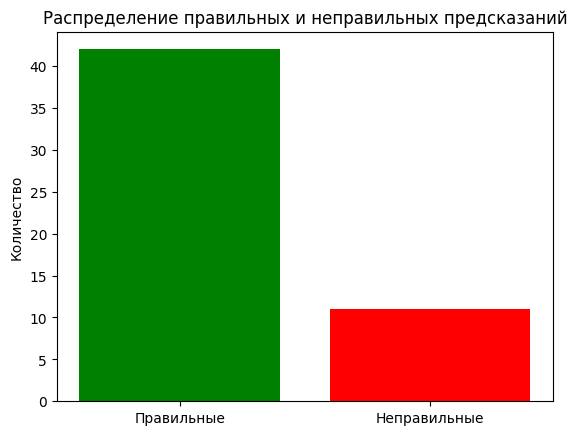

            URL-адрес веб-сайта Начальная категория Предсказанная категория  \
12            https://boosty.to     Развлекательные      Business/Corporate   
13         https://kinopoisk.ru     Развлекательные               Education   
16         https://postnauka.ru         Образование      Streaming Services   
22           https://openedu.ru         Образование      Streaming Services   
34  https://scientificrussia.ru         Образование      Streaming Services   
36          https://infourok.ru         Образование      Streaming Services   
41           https://edumail.ru         Образование      Streaming Services   
47         https://umschool.net         Образование      Streaming Services   
49           https://tiktok.com     Развлекательные               Education   
50         https://kinopoisk.ru     Развлекательные               Education   
51            https://vkplay.ru     Развлекательные               Education   

   Соотнесенная категория  Правильность предсказани

In [66]:
demodata = demodata.rename(columns={'Категория URL-адреса': 'Начальная категория'})
final_data = final_data.rename(columns={'Категория URL-адреса': 'Предсказанная категория'})

# Объединение DataFrame по полю 'URL-адрес веб-сайта'
merged_data = pd.merge(demodata, final_data, on='URL-адрес веб-сайта')

# Удаление строк с пустыми значениями
merged_data = merged_data.dropna()

# Соотнесение категорий
education_categories = ['Education', 'Business/Corporate', 'Food', 'Travel', 'News']
entertainment_categories = ['Streaming Services', 'Photography']

def map_category(predicted_category):
    if predicted_category in education_categories:
        return 'Образование'
    elif predicted_category in entertainment_categories:
        return 'Развлекательные'
    else:
        return 'Unknown'

merged_data['Соотнесенная категория'] = merged_data['Предсказанная категория'].apply(map_category)

# Подсчет количества правильных и неправильных предсказаний
merged_data['Правильность предсказания'] = merged_data['Начальная категория'] == merged_data['Соотнесенная категория']
incorrect_predictions = merged_data[merged_data['Правильность предсказания'] == False]

# Построение графика
labels = ['Правильные', 'Неправильные']
correct_count = merged_data['Правильность предсказания'].sum()
incorrect_count = len(merged_data) - correct_count
counts = [correct_count, incorrect_count]

plt.bar(labels, counts, color=['green', 'red'])
plt.title('Распределение правильных и неправильных предсказаний')
plt.ylabel('Количество')
plt.show()

# Вывод процента правильно предсказанных категорий
accuracy = correct_count / len(merged_data) * 100

# Вывод неправильных предсказаний
print(incorrect_predictions)
print(f"Процент правильно предсказанных категорий: {accuracy:.2f}%")

# Заключение
Модель правильно предсказывает до 80% новых сайтов, что очень высокий показатель. 
## Погрешность возникает при:
- Малой наполнености страницы контентом, то есть на странице мало информации или вся она визуально понятная только для человека.
- Проблем с переводом текста на английский язык.